In [31]:
import re
import os
import json

In [4]:
def get_env_shape(folder):
    # Reads the metadata.json file in the given folder and returns the shape of the environment
    with open(folder + '/metadata.json') as f:
        data = json.load(f)
        return data['shape']


def load_envs(folder, shape):
    # Loads folder into a dictonary of environments of the given shape

    patt = "F_(\d+)(-L_(\d+))?.png"
    food_maps = {}  # food map index -> food map filename
    life_maps = {}  # food map index -> (life map index -> filename)

    for entry in os.scandir(path=os.fsencode(folder)):
        if entry.name.endswith(b".png"):
            mtch = re.search(patt, str(entry.name))
            if mtch is not None:
                grps = mtch.groups()

                # If food map index is not in the lifemap dictionary, add it
                if grps[0] not in life_maps:
                    life_maps[grps[0]] = {}
                # If the life map index is not None, add its contents to the life map dictionary
                if grps[2] is not None:
                    life_maps[grps[0]][grps[2]] = entry.path.decode()
                # If the food map index is not None, add its contents to the food map dictionary
                elif grps[0] is not None:
                    if grps[0] not in food_maps:
                        food_maps[grps[0]] = entry.path.decode()
    envs = {}
    for fmap_k in food_maps.keys():
        envs[fmap_k] = {}
        for lmap_k in life_maps[fmap_k].keys():
            env = CAEnvironment(
                id=f"test_{shape[0]}x{shape[1]}_F_{fmap_k}-L_{lmap_k}")
            env.update_shape(shape)
            env.set_channel(env.food_i, food_maps[fmap_k])
            env.set_channel(env.life_i, life_maps[fmap_k][lmap_k])
            envs[fmap_k][lmap_k] = env
    return envs


def load_tests(folder):
    # Walks through the subfolders, gathers their metadata, and adds their environments
    # to a dictionary whose key is the metadata title
    tests = {}
    for entry in os.scandir(path=os.fsencode(folder)):
        if entry.is_dir():
            shape = get_env_shape(entry.path.decode())
            tests[entry.name.decode()] = load_envs(entry.path.decode(), shape)

In [5]:
load_tests("./data/mold_test_imgs/")

TypeError: __init__() got an unexpected keyword argument 'id'

In [ ]:
import configparser

# Loads the config file passed in as a parameter
def load_config(config_file):
    config = configparser.ConfigParser()
    config.read(config_file)
    return config

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
cmaps = ['gray', 'blue']
chs = [1,2,3,4,5]
if len(cmaps) < len(chs):
    cmaps += [cmaps[-1]] * (len(chs) - len(cmaps))
cmaps

['gray', 'blue', 'blue', 'blue', 'blue']

In [120]:
from importlib import reload
import encasm.env
reload(encasm.env)
from encasm.env import PetriDish

In [121]:
test_env = PetriDish.from_config_file("test", "./encasm/configs/default_config.ini")

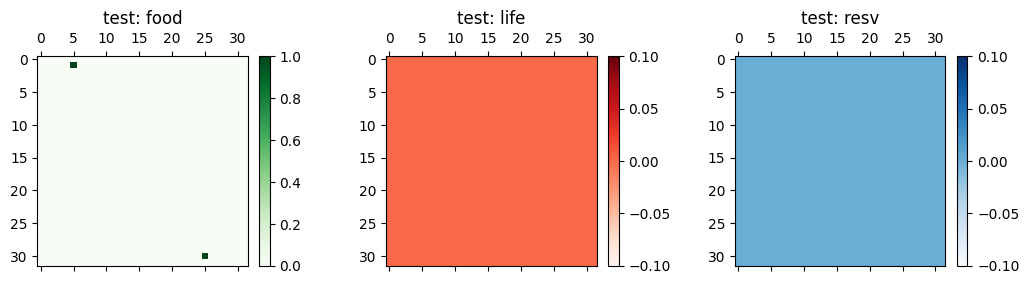

In [122]:
test_env.generate_food()

test_env.display()

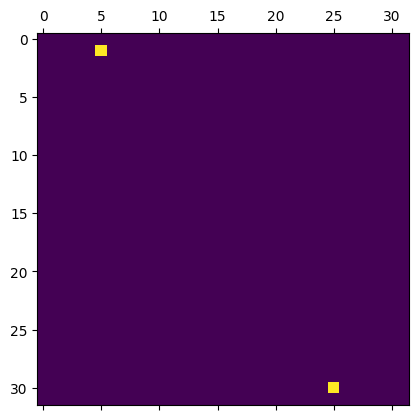

In [142]:
test_env.food = np.random.rand(32,32)
plt.matshow(test_env.channels[...,0])

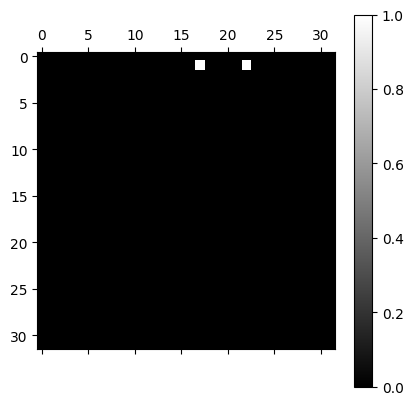

In [77]:
plt.matshow(test_env.food, cmap='gray')
plt.colorbar()

In [156]:
import encasm
reload(encasm)
import encasm.eval
reload(encasm.eval)
from encasm.eval import load_tests

data_dir = "./encasm/example_networks/"
test_envs = load_tests(folder = data_dir)

b'F_6-L_3.png'
b'F_6-L_2.png'
b'F_6-L_1.png'
b'F_6-L_5.png'
b'F_6-L_4.png'
b'F_6.png'
b'F_3.png'
b'F_2.png'
b'F_5-L_1.png'
b'F_1.png'
b'F_5-L_2.png'
b'F_4-L_3.png'
b'F_5.png'
b'F_4.png'
b'F_4-L_2.png'
b'F_4-L_1.png'
b'F_1-L_1.png'
b'F_1-L_2.png'
b'F_1-L_3.png'
b'F_2-L_2.png'
b'F_2-L_3.png'
b'F_2-L_1.png'
b'F_2-L_4.png'
b'F_3-L_1.png'
b'F_3-L_2.png'


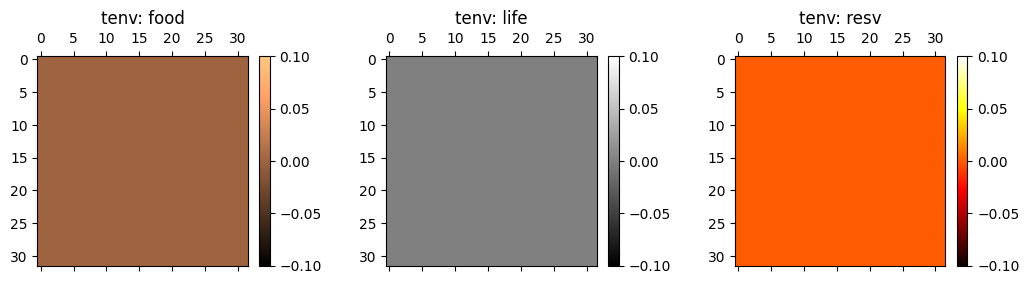

In [154]:
import encasm.env
reload(encasm.env)
from encasm.env import PetriDish
tenv = PetriDish.from_env("tenv", test_envs["small"]['3']['1'])
tenv.display()